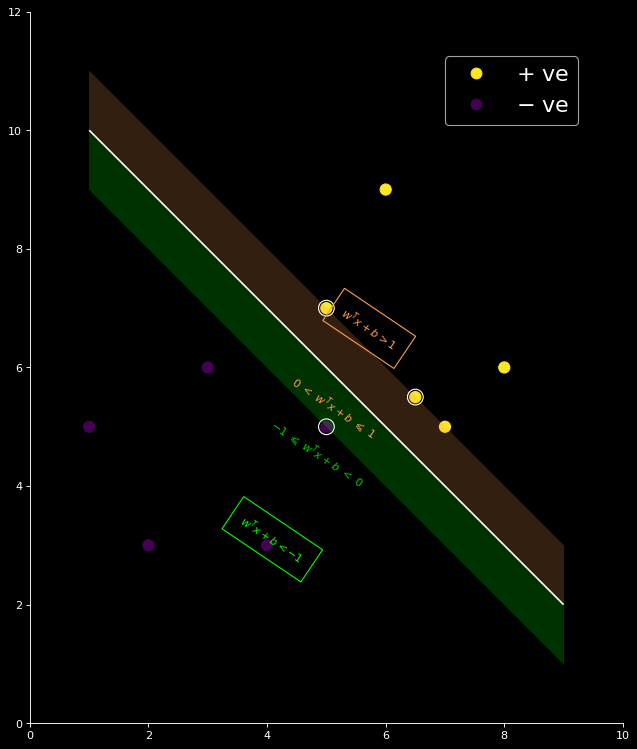

In [10]:
import matplotlib.pyplot as plt

with plt.style.context('dark_background'):  # just to make the background black
    fig = plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w')
    # set the x-axis and y-axis limits
    plt.xlim(0,10)
    plt.ylim(0,12)
    
    # plot data
    scatter = plt.scatter(X[:,0], X[:,1], c=y, s=100)
    plt.legend(handles=scatter.legend_elements()[0][::-1], labels=['$+$ ve', '$-$ ve'],
               fontsize=20, markerscale=1.6,borderaxespad=2)
    # ########### decision function ########### #
    ax = plt.gca()  # get_current_axes
    # create grid of points
    xx = np.linspace(ax.get_xlim()[0]+1, ax.get_xlim()[1]-1, 30)
    yy = np.linspace(ax.get_ylim()[0]+1, ax.get_ylim()[1]-1, 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    # find the decision function output for those grid of points
    Z = clf.decision_function(xy).reshape(XX.shape)
    # plot decision boundary (where decision function outputs are -1,0 or 1)
    # which are margins.
    colors=[(0, 1, 0, 1.0),(1,1,1,1),(1, 0.61, 0.33, 1.0)]
    ax.contour(XX, YY, Z, colors='w', levels=[0],
               linestyles=['-'])
    colors=[(0, 1, 0, 0.2),(1,1,1,0),(1, 0.61, 0.33, 0.2)]
    ax.contourf(XX, YY, Z, colors=colors, levels=[-0.99, -0.01, 0.01, 0.99])

    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=200,
               linewidth=1, facecolors='none', edgecolors='white')
    
    # save figure
    plt.tight_layout(pad=3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.patch.set_facecolor("black")
    
    orange_interior = (1, 0.61, 0.33, 1.0)
    plt.annotate(text="$w^Tx+b>1$", xy=(5.2,6.3),  rotation=-34,
                 color=orange_interior, bbox=dict(facecolor='none', edgecolor=orange_interior, pad=10))
    plt.annotate(text=r"$0\ <\ w^Tx+b\ \leqslant\ 1$", xy=(4.35,4.8),  rotation=-34,
                 color=(1, 0.61, 0.33, 1))
    plt.annotate(text=r"$-1\ \leqslant\ w^Tx+b\ <\ 0$", xy=(4,4),  rotation=-34,
                 color=(0, 0.8, 0, 1.0))
    green_interior = (0, 1, 0, 1.0)
    plt.annotate(text=r"$w^Tx+b<-1$", xy=(3.5,2.7),  rotation=-34,
                 color=green_interior, bbox=dict(facecolor='none', edgecolor=green_interior, pad=10))
    
    plt.savefig("linear_SVM.png", dpi=80)
    plt.gca().set_aspect('equal')
    plt.show()

In [11]:
print(clf.dual_coef_)

[[-1.          0.66666667  0.33333333]]


/tmp/ipykernel_4089/797705359.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels, cmap=matplotlib.cm.get_cmap('RdYlBu_r'))


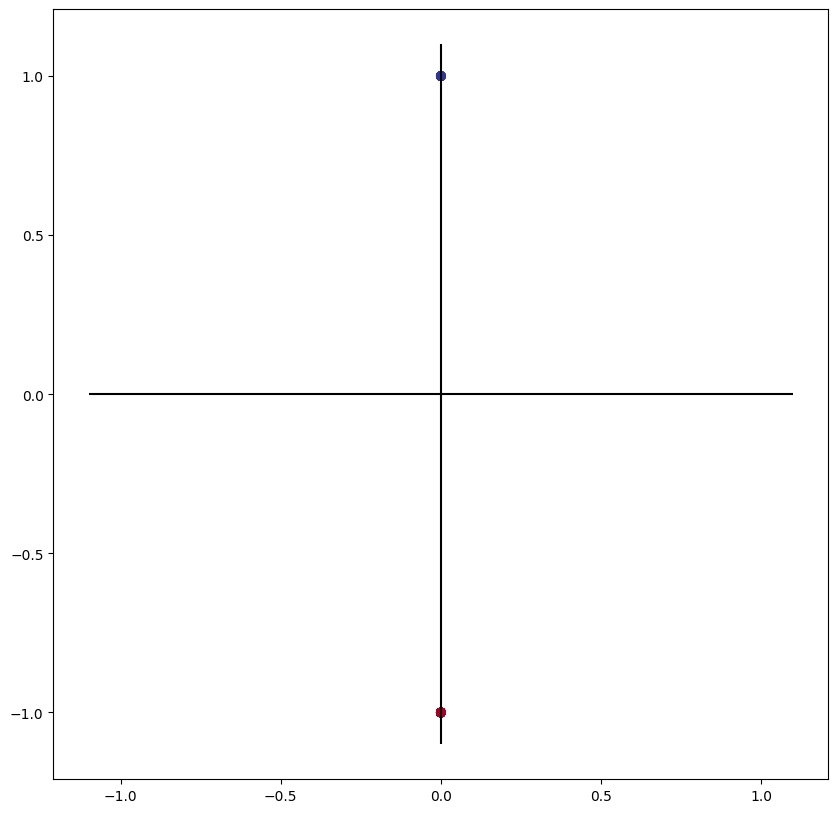

In [1]:
import os, sys, numpy, torch, matplotlib.pyplot, matplotlib.cm, ipycanvas, matplotlib.patches

sys.path += [os.path.abspath(os.path.join('..')), os.path.abspath(os.path.join('../..'))]  # Allow repository modules to be imported

from functools import partial
from utils.optimization import initialize
from utils.plots import (plot_train_loss, plot_samples_and_neurons, plot_weights_norms, 
                         plot_norms_min_max_variation, draw_figure_into_canvas, save_figure)
from utils.models import FullyConnectedNeuralNetwork
from settings.gaussian_clusters import get_dataloader
from experiment import model_summary, plot_neurons_inner_product_to_weights_products, execute_experiment

clusters_means = [[0, 1],] + [[0, -1], ] * 3
clusters_labels = [-1.,] + [1.,] * 3

experiment = {
    'dataset': 'sphere_2d_epsilon_net',
    'epsilon': 2,
    'net_epsilon': 2,
    'seed': 2,
    'input_dimension': 2, 
    'sample_size': 100,  
    'batch_size': 100, 
    'within_cluster_variance': 0,
    'epochs': 3000,
    'learning_rate': .1,
    'initial_hidden_units': 2,
    'bias': False,
    'initialization_scale': 1e-5,
    'name_parameters': ['seed'],
    'initial_weights': [
        [[0., 1e-5], [0., -1e-5]]
    ],
    'output_layer_initial_weights': [-1e-5, 1e-5],
    'regularization': 1e-2
}
rotation_matrix = numpy.identity(experiment['input_dimension'])
device, generator = initialize(experiment['seed'])
data_args = dict(clusters_means=clusters_means, clusters_labels=clusters_labels, rotation_matrix=rotation_matrix, **experiment)
train_data, test_data = get_dataloader(**data_args), get_dataloader(**data_args)

fig, ax = matplotlib.pyplot.subplots(figsize=(10, 10))
inputs = []; labels = []
for batch_inputs, batch_labels in train_data: inputs.append(batch_inputs); labels.append(batch_labels)
inputs, labels = torch.concatenate(inputs), torch.concatenate(labels)
inputs_ = numpy.matmul(inputs.detach().cpu().numpy(), rotation_matrix.transpose())
ax.hlines(0, -inputs_.max() * 1.1, inputs_.max() * 1.1, color='k')
ax.vlines(0, -inputs_.max() * 1.1, inputs_.max() * 1.1, color='k')
ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels, cmap=matplotlib.cm.get_cmap('RdYlBu_r'))

In [14]:
matplotlib.pyplot.ioff()
figure, ((input_domain_ax, loss_ax), (parameters_norms_ax, inner_product_to_weights_product_ax)) = matplotlib.pyplot.subplots(2, 2, figsize=(16, 16))

canvas = ipycanvas.Canvas()
canvas.width, canvas.height = 1200, 1200
canvas.font = '30px arial'
canvas.fill_text('Results will appear as processed', canvas.width / 4, canvas.height / 3)

plot_samples_and_neurons = partial(plot_samples_and_neurons, ax=input_domain_ax, rotation_matrix=rotation_matrix, dataloader=train_data, label_neurons=True)
plot_train_loss = partial(plot_train_loss, ax=loss_ax)
plot_weights_norms = partial(plot_weights_norms, ax=parameters_norms_ax)
plot_neurons_inner_product_to_weights_products = partial(plot_neurons_inner_product_to_weights_products, ax=inner_product_to_weights_product_ax, aggregate_neurons=False)
draw_figure_into_canvas = partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
save_figure = partial(save_figure, figure=figure, parameters=experiment, **experiment)

canvas

Canvas(height=1200, width=1200)

In [15]:
execute_experiment(
    **experiment,
    train_data=train_data, 
    test_data=test_data, 
    model_class=FullyConnectedNeuralNetwork,
    saving_epochs_interval=experiment['epochs'],
    callbacks_epochs=list(range(0, experiment['epochs'], 100)),
    callbacks=[model_summary, plot_samples_and_neurons, plot_train_loss, plot_weights_norms, 
               plot_neurons_inner_product_to_weights_products, draw_figure_into_canvas, save_figure],
    overwrite=True
)